# 0. Imports & Read in data

In [ ]:
!pip install datasets evaluate rouge-score
!pip install transformers[torch]
!pip install accelerate -U

In [130]:
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
import evaluate
rouge = evaluate.load("rouge")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from huggingface_hub import notebook_login

In [ ]:
# Authenticate with Hugging Face (login) to access the model hub
#notebook_login()

In [82]:
dataset = load_dataset("EE21/ToS-Summaries", split='train')

In [83]:
dataset = dataset.train_test_split(test_size=0.2)

# 1. Understanding the data

In [97]:
# Convert the training and testing splits to DataFrames
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

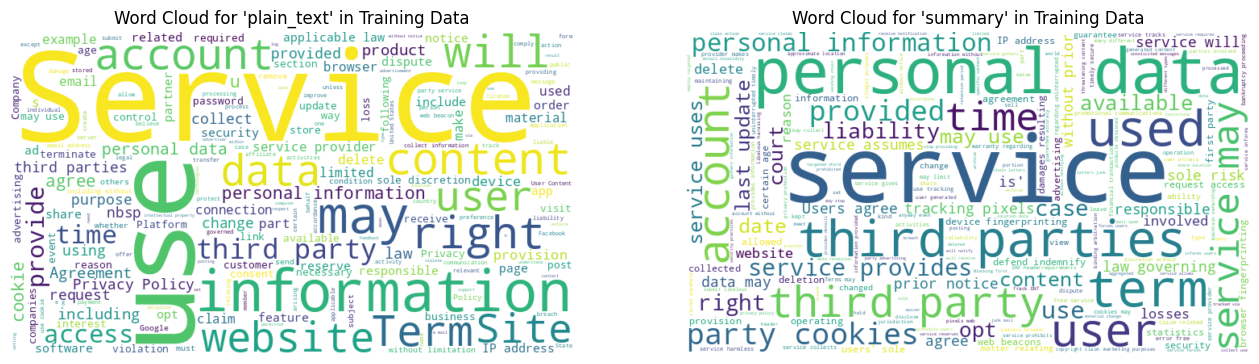

In [114]:
# Create a word cloud for the "plain_text" column in the training data
train_plain_text = " ".join(train_df['plain_text'].tolist())
wordcloud_plain_text = WordCloud(width=700, height=400, background_color='white').generate(train_plain_text)

# Create a word cloud for the "summary" column in the training data
train_summary = " ".join(train_df['summary'].tolist())
wordcloud_summary = WordCloud(width=700, height=400, background_color='white').generate(train_summary)

# Plot the word clouds side by side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_plain_text, interpolation='bilinear')
plt.title("Word Cloud for 'plain_text' in Training Data")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title("Word Cloud for 'summary' in Training Data")
plt.axis('off')

plt.show()

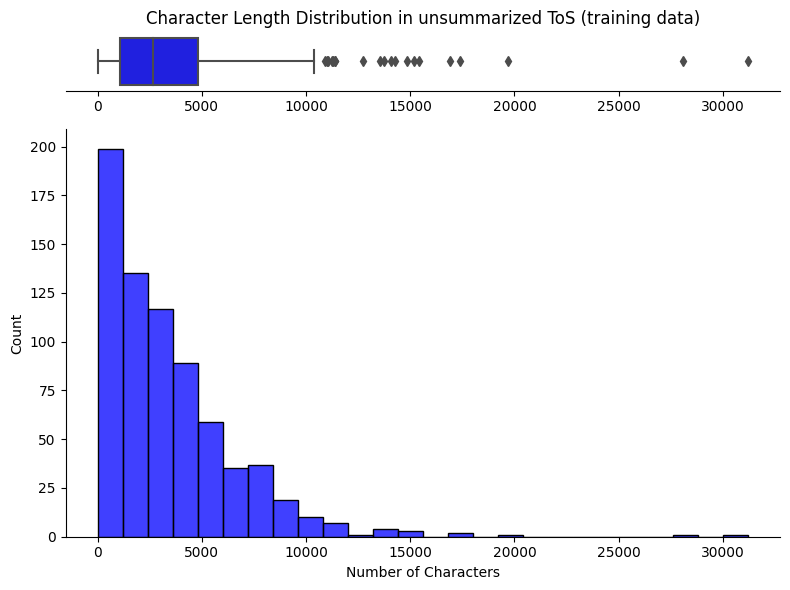

In [176]:
# Choose a color for both the box plot and histogram
plot_color = 'blue'

# Create subplots with shared x-axis and custom heights
fig, (ax_box_plain, ax_hist_plain) = plt.subplots(2, figsize=(8, 6),
                                                  gridspec_kw={"height_ratios": [0.1, 0.7]})

# Character Length Distribution in 'plain_text' (Box Plot)
sns.boxplot(x=train_df['plain_text'].str.len(), ax=ax_box_plain, color=plot_color)
ax_box_plain.set(yticks=[], title='Character Length Distribution in unsummarized ToS (training data)')

# Remove x-axis label in the box plot
ax_box_plain.set_xlabel("")

# Character Length Distribution in 'plain_text' (Histogram)
sns.histplot(train_df['plain_text'].str.len(), bins=26, ax=ax_hist_plain, color=plot_color)

# Set x-axis label to "Number of Characters" for the histogram
ax_hist_plain.set_xlabel("Number of Characters")

# Remove spines
sns.despine(ax=ax_hist_plain)
sns.despine(ax=ax_box_plain, left=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

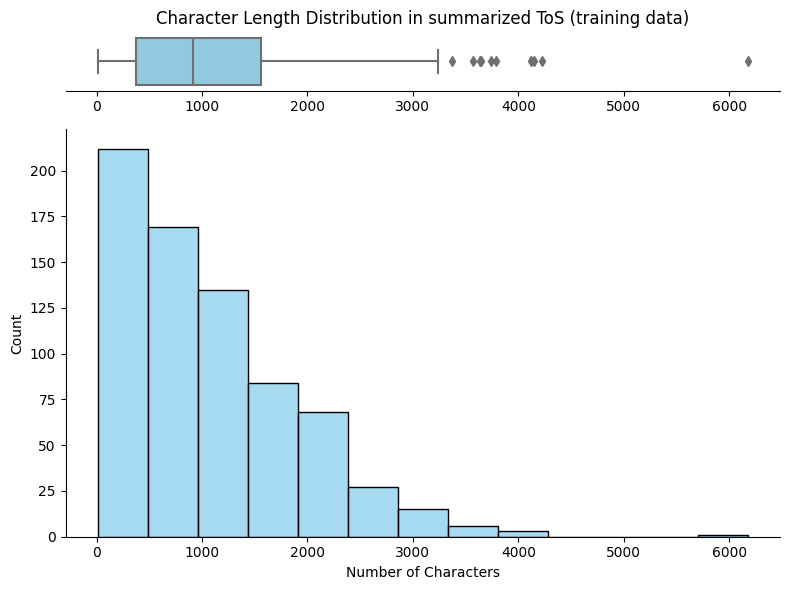

In [173]:
# Choose a color for both the box plot and histogram for 'summaries'
plot_color_summary = 'skyblue'

# Create subplots with shared x-axis and custom heights
fig, (ax_box_summary, ax_hist_summary) = plt.subplots(2, figsize=(8, 6),
                                                      gridspec_kw={"height_ratios": [0.1, 0.7]})

# Character Length Distribution in 'summaries' (Box Plot)
sns.boxplot(x=train_df['summary'].str.len(), ax=ax_box_summary, color=plot_color_summary)
ax_box_summary.set(yticks=[], title='Character Length Distribution in summarized ToS (training data)')

# Remove x-axis label in the box plot for 'summaries'
ax_box_summary.set_xlabel("")

# Character Length Distribution in 'summaries' (Histogram)
sns.histplot(train_df['summary'].str.len(), bins=13, ax=ax_hist_summary, color=plot_color_summary)

# Set x-axis label to "Number of Characters" for the histogram for 'summaries'
ax_hist_summary.set_xlabel("Number of Characters")

# Remove spines
sns.despine(ax=ax_hist_summary)
sns.despine(ax=ax_box_summary, left=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# 2. Preprocess

In [ ]:
# Define the checkpoint (pre-trained model) you want to use for summarization
checkpoint = "facebook/bart-large-cnn"

# Load the tokenizer associated with the specified checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [81]:
# Define a prefix that will be added to each document for summarization
prefix = "summarize: "

# Define a function for preprocessing data for a summarization model
def preprocess_function(data):
    # Combine the prefix with each document and create a list of inputs
    inputs = [prefix + doc for doc in data["plain_text"]]

    # Tokenize the inputs with a maximum length of 256 tokens and truncation
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)

    # Tokenize the summary (target) text with a maximum length of 128 tokens and truncation
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)

    # Add the tokenized labels (input_ids) to the model_inputs dictionary
    model_inputs["labels"] = labels["input_ids"]

    # Return the preprocessed data as model inputs
    return model_inputs


In [ ]:
# Apply a preprocessing function to the dataset in batches
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [85]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['plain_text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 720
    })
    test: Dataset({
        features: ['plain_text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 181
    })
})

# 3. Fine-Tuning

In [86]:
def compute_metrics(eval_pred):
    # Extract predictions and labels from the evaluation prediction tuple
    predictions, labels = eval_pred

    # Decode the model's predictions into human-readable text, skipping special tokens
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace label values of -100 (usually representing padding) with the pad token ID
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode the labels into human-readable text, skipping special tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE (a metric for text summarization) scores using the decoded predictions and labels
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculate the average length of generated predictions (excluding padding)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    # Round the computed metrics to four decimal places and return as a dictionary
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Load a pre-trained sequence-to-sequence language model from the specified checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [88]:
# Create a data collator for sequence-to-sequence tasks using the provided tokenizer and model checkpoint
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="BART-ToSSimplify",
    evaluation_strategy="epoch",
    learning_rate=5e-05,
    lr_scheduler_type="linear",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    num_train_epochs=5,
    warmup_steps=500,
    predict_with_generate=True,
    push_to_hub=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Push model to huggingface

In [ ]:
#trainer.push_to_hub()